In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
# here we are working on Tensorflow version 2.1.0 so we need to write tensorflow.keras.
#keras is in built function in Tensorflow.
import os
import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image

In [ ]:
train_location = "/content/drive/MyDrive/CNN 2k22/Dataset"
test_location = "/content/drive/MyDrive/CNN 2k22/Dataset"
filepath = '/content/drive/MyDrive/CNN 2k22/program/program2/model/Fruit_MobileNet_model_M2.h5'

In [ ]:
preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
img_size=224
batch_size=10
num_class=12

In [ ]:
# Complete Dataset images can be loaded using ImageDataGenerator function

datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory(train_location,target_size=(img_size,img_size),batch_size=batch_size,class_mode='categorical',shuffle=True)

datagen_test=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_test.flow_from_directory(test_location,target_size=(img_size,img_size),batch_size=batch_size,class_mode='categorical',shuffle=True)


Found 288 images belonging to 12 classes.
Found 288 images belonging to 12 classes.


In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
#model = MobileNetV2(weights='imagenet')
model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model = model

In [ ]:
#base_model = tensorflow.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# [CREATE THE MODEL ARCHITECTURE]

# exclude the last 5 layers of the above model
x = base_model.layers[-6].output

# create a new dense layer for predictions
# flatten the output layer to 1 dimension
x = tensorflow.keras.layers.Flatten()(x)
# create a new dense layer for predictions
x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
# 7 corresponds to the number of classes
x = tensorflow.keras.layers.Dropout(0.25)(x)
predictions = tensorflow.keras.layers.Dense(num_class, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer created above

detection = tensorflow.keras.models.Model(inputs=base_model.input, outputs=predictions)

# choose how many layers I actually want to be trained

# freeze the weights of all layers except the last 23 layers in the new model
# the last 23 layers of the model will be trained.

for layer in detection.layers[:-23]:
    layer.trainable = False

In [ ]:
detection.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
optimum=Adam(learning_rate=0.005)
detection.compile(optimizer=optimum,loss='categorical_crossentropy',metrics=['accuracy'])



In [ ]:
print(train_generator.class_indices)


{'Apple_Bad': 0, 'Apple_Good': 1, 'Banana_Bad': 2, 'Banana_Good': 3, 'Guava_Bad': 4, 'Guava_Good': 5, 'Lime_Good': 6, 'Line_Bad': 7, 'Orange_Bad': 8, 'Orange_Good': 9, 'Pomegranate_Bad': 10, 'Pomegranate_Good': 11}


In [ ]:
TRAIN_STEPS=train_generator.n//train_generator.batch_size
TRAIN_STEPS

28

In [ ]:
VALIDATION_STEPS=validation_generator.n//validation_generator.batch_size
VALIDATION_STEPS

28

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2, 
                              verbose=1,
                              mode='max',
                              min_lr=0.00001)

In [ ]:
callbacks_list = [checkpoint, reduce_lr]
#callbacks_list = [checkpoint]

In [ ]:
#history = detection.fit_generator(train_generator,
history = detection.fit(train_generator,
                              steps_per_epoch=TRAIN_STEPS, 
                              #class_weight=class_weights,
                              validation_data=validation_generator,
                              validation_steps=VALIDATION_STEPS,
                              epochs=80,
                              verbose=1,
                              callbacks=callbacks_list
                             )

Epoch 1/80
28/28 [==============================] - ETA: 0s - loss: 369.3647 - accuracy: 0.1727
Epoch 1: val_accuracy improved from -inf to 0.23571, saving model to /content/drive/MyDrive/CNN 2k22/program/program2/model/Fruit_MobileNet_model_M2.h5
28/28 [==============================] - 154s 5s/step - loss: 369.3647 - accuracy: 0.1727 - val_loss: 261.8421 - val_accuracy: 0.2357 - lr: 0.0050
Epoch 2/80
28/28 [==============================] - ETA: 0s - loss: 19.8280 - accuracy: 0.4856
Epoch 2: val_accuracy did not improve from 0.23571
28/28 [==============================] - 2s 82ms/step - loss: 19.8280 - accuracy: 0.4856 - val_loss: 223.5541 - val_accuracy: 0.1429 - lr: 0.0050
Epoch 3/80
27/28 [===========================>..] - ETA: 0s - loss: 3.7077 - accuracy: 0.4701
Epoch 3: val_accuracy did not improve from 0.23571

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
28/28 [==============================] - 2s 83ms/step - loss: 3.6679 - accuracy: 0.4604 - v

In [ ]:
# get the metric names so I can use evaulate_generator
detection.metrics_names

['loss', 'accuracy']

In [ ]:
# here the the last epoch will be used.

detection.evaluate_generator(validation_generator,steps=TRAIN_STEPS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.23216760158538818, 0.925000011920929]

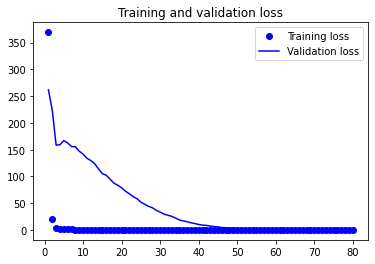

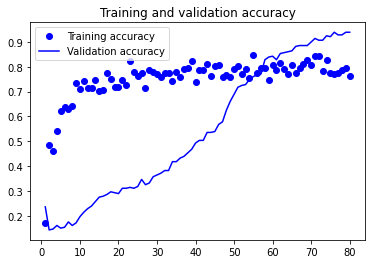

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
epochs

range(1, 81)

In [ ]:
loss

[369.36468505859375,
 19.82796287536621,
 3.667936325073242,
 1.3436237573623657,
 1.2361711263656616,
 1.0162752866744995,
 0.9935165643692017,
 0.9492413401603699,
 0.7681043148040771,
 0.8789517283439636,
 0.7553941607475281,
 0.8075438737869263,
 0.7495008111000061,
 0.6923794150352478,
 0.8728077411651611,
 0.7682552337646484,
 0.6332570314407349,
 0.6416249871253967,
 0.7309785485267639,
 0.7845922708511353,
 0.678066611289978,
 0.7320505380630493,
 0.5912783145904541,
 0.5982617735862732,
 0.6151136755943298,
 0.6368061304092407,
 0.7251388430595398,
 0.6380776762962341,
 0.5889264941215515,
 0.6151257157325745,
 0.6685700416564941,
 0.6187310218811035,
 0.6037805080413818,
 0.6550790071487427,
 0.6046243906021118,
 0.6831700205802917,
 0.5423644781112671,
 0.616502583026886,
 0.5587529540061951,
 0.7038513422012329,
 0.5572169423103333,
 0.5870120525360107,
 0.5409865975379944,
 0.615990936756134,
 0.5751195549964905,
 0.5507898926734924,
 0.5949214100837708,
 0.637671709060669

In [ ]:
val_loss

[2447.813232421875,
 1873.8143310546875,
 1409.6590576171875,
 657.7916870117188,
 287.65875244140625,
 94.38907623291016,
 61.59649658203125,
 17.584918975830078,
 2.9393646717071533,
 18.660377502441406,
 46.87237548828125,
 15.822667121887207,
 2.136348009109497,
 0.06325989961624146,
 0.009885875508189201,
 0.001960448455065489,
 0.0011084459256380796,
 0.0010562656680122018,
 0.0005090736667625606,
 0.0005481113330461085,
 0.0004917011829093099,
 0.0004425148363225162,
 0.0004995468189008534,
 0.0004828348755836487,
 0.0005050698528066278,
 0.0004921298241242766,
 0.0005837490316480398,
 0.0004278062842786312,
 0.00026859689387492836,
 0.0002612513198982924,
 0.00032151013147085905,
 0.0003638349589891732,
 0.000491567247081548,
 0.00032896921038627625,
 0.0004383038613013923,
 0.0003539329336490482,
 0.00035447717527858913,
 0.00023852360027376562,
 0.00042832360486499965,
 0.0003736327635124326,
 0.0004536556953098625,
 0.0004248080949764699,
 0.00043028342770412564,
 0.00036107

In [ ]:
acc

[0.3956834673881531,
 0.7589927911758423,
 0.8345323801040649,
 0.8884891867637634,
 0.8884891867637634,
 0.8992805480957031,
 0.9064748287200928,
 0.9136690497398376,
 0.9460431933403015,
 0.9604316353797913,
 0.8597122430801392,
 0.902877688407898,
 0.9532374143600464,
 0.9604316353797913,
 0.9820144176483154,
 1.0,
 0.9784172773361206,
 0.9964028596878052,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 0.9928057789802551,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 0.9892086386680603,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 1.0,
 1.0,
 0.9964028596878052,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 0.9928057789802551,
 1.0,
 1.0,
 0.9928057789802551,
 1.0,
 0.9928057789802551,
 1.0,
 1.0,
 0.9964028596878052,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 1.0,
 0.9928057789802551,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 1.0,
 1.0,
 0.9964028596878052,
 0.9964028596878052,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9964028596878052,
 1.0,
 1.0,
 0

In [ ]:
val_acc

[0.07500000298023224,
 0.08214285969734192,
 0.08571428805589676,
 0.20000000298023224,
 0.30714285373687744,
 0.4285714328289032,
 0.5035714507102966,
 0.6821428537368774,
 0.8714285492897034,
 0.6321428418159485,
 0.32499998807907104,
 0.5428571701049805,
 0.8357142806053162,
 0.9857142567634583,
 0.9964285492897034,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]